In [1]:
import os
os.environ["DISABLE_TQDM"] = "1"                 # disable tqdm bars in many libs
os.environ["HF_HUB_DISABLE_PROGRESS_BARS"] = "1" # disable HF hub bars
try:
    from datasets.utils.logging import disable_progress_bar
    disable_progress_bar()
except Exception:
    pass


In [2]:
# Fraud-focused LoRA fine-tune + adversarial generation loop
# macOS-friendly (MPS / CPU compatible)
# Save as fraud_lora_adversarial.py or paste into Jupyter cells

import os
import json
import random
import time
from pathlib import Path
from typing import List, Dict

In [3]:
import pandas as pd
import numpy as np
from datasets import Dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.model_selection import train_test_split

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, Trainer, TrainingArguments, pipeline
from peft import LoraConfig, get_peft_model, set_peft_model_state_dict

In [5]:
# -------------- User settings --------------
MODEL_NAME = "microsoft/Phi-3-mini-4k-instruct"
FINETUNE_DIR = "./fraud_lora_model"
FRAUD_OVERSAMPLE_FACTOR = 10   # replicate each fraud row this many times during fine-tune
NUM_GENERATED_PER_LOOP = 1000  # how many synthetic samples to generate in each adversarial loop
ADVERSARIAL_LOOPS = 3         # number of adversarial iterations
SEED = 42
DEVICE = "mps" if torch.backends.mps.is_available() else ("cpu" if not torch.cuda.is_available() else "cuda")
# -------------------------------------------

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print("Device:", DEVICE)

Device: mps


In [6]:

# ============================
# 1) Load data and prepare
# ============================
csv_path = r"Credit Card Data.csv"
df_whole = pd.read_csv(csv_path, low_memory=False)
n_samples = 20000
df = df_whole.sample(n=n_samples, random_state=42)
print("Loaded dataset:", df.shape)

# Basic minimal required columns expected (adapt if your schema differs)
required_cols = ['Unnamed: 0','trans_date_trans_time','cc_num','merchant','category','amt','first','last','gender',
                 'street','city','state','zip','lat','long','city_pop','job','dob','trans_num','unix_time',
                 'merch_lat','merch_long','is_fraud','merch_zipcode']
# If not all present, we won't fail — the serialization will use available columns.

# Make a small sampled version for quicker development if dataset is huge (uncomment if needed)
# df = df.sample(min(len(df), 20000), random_state=SEED).reset_index(drop=True)

# Split real data into train / holdout (for TSTR evaluation)
train_real, holdout_real = train_test_split(df, test_size=0.2, stratify=df['is_fraud'] if 'is_fraud' in df.columns else None, random_state=SEED)
print("Train real:", train_real.shape, "Holdout real:", holdout_real.shape)

Loaded dataset: (20000, 24)
Train real: (16000, 24) Holdout real: (4000, 24)


In [7]:
# ============================
# 2) Helper: serialization
# ============================
def serialize_row_for_lm(row: pd.Series) -> str:
    """Serialize a transaction row into a compact labeled string for LM fine-tuning."""
    # Build safe masked PAN (mask middle digits)
    cc = str(row.get('cc_num', '')) 
    if len(cc) >= 8:
        cc_masked = cc[:4] + "XXXXXXXX" + cc[-4:]
    else:
        cc_masked = cc

    fields = {
        "trans_date_trans_time": row.get('trans_date_trans_time', ""),
        "cc_num": cc_masked,
        "merchant": row.get('merchant', ""),
        "category": row.get('category', ""),
        "amt": f"{row.get('amt', ''):.2f}" if pd.notnull(row.get('amt', None)) else "",
        "first": row.get('first', ""),
        "last": row.get('last', ""),
        "gender": row.get('gender', ""),
        "city": row.get('city', ""),
        "state": row.get('state', ""),
        "zip": row.get('zip', ""),
        "job": row.get('job', ""),
        "dob": row.get('dob', ""),
        "is_fraud": int(row.get('is_fraud', 0))
    }
    # Optional reason if present
    reason = row.get('reason', "")
    base = " | ".join([f"{k}:{v}" for k, v in fields.items()])
    if reason:
        base += f" | reason:{reason}"
    return base

# Create train texts oversampling fraud rows
def make_fraud_oversampled_texts(df_train: pd.DataFrame, oversample_factor: int = 10) -> List[str]:
    fraud_df = df_train[df_train['is_fraud'] == 1] if 'is_fraud' in df_train.columns else pd.DataFrame()
    nonfraud_df = df_train[df_train['is_fraud'] == 0] if 'is_fraud' in df_train.columns else df_train
    texts = []
    # Oversample fraud heavily
    if not fraud_df.empty:
        for _, r in fraud_df.iterrows():
            for _ in range(oversample_factor):
                texts.append(serialize_row_for_lm(r))
    # Add non-fraud (optionally downsample if huge)
    sample_nonfraud = nonfraud_df.sample(min(len(nonfraud_df), max(20000, len(fraud_df)*oversample_factor*2)), random_state=SEED) if not nonfraud_df.empty else nonfraud_df
    for _, r in sample_nonfraud.iterrows():
        texts.append(serialize_row_for_lm(r))
    random.shuffle(texts)
    return texts

print("Preparing fine-tune texts (oversampling fraud)...")
train_texts = make_fraud_oversampled_texts(train_real, oversample_factor=FRAUD_OVERSAMPLE_FACTOR)
print("Prepared texts:", len(train_texts))

# Create a datasets.Dataset for trainer
ds = Dataset.from_dict({"text": train_texts}).train_test_split(test_size=0.05)

Preparing fine-tune texts (oversampling fraud)...
Prepared texts: 16855


In [8]:
print(MODEL_NAME)


microsoft/Phi-3-mini-4k-instruct


In [9]:
import os, torch, json, re
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, pipeline
from peft import LoraConfig, get_peft_model

# 1) Choose a real model id (public)
MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
HF_TOKEN = os.environ.get("HF_TOKEN", None)  # optional for public models

print("Loading tokenizer and base model…")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True, token=HF_TOKEN)

# Load on a single device first to avoid `meta` offloading before PEFT
base = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16 if torch.cuda.is_available() else None,
    device_map=None,
    trust_remote_code=True,
    token=HF_TOKEN,
)

# Choose target modules for TinyLlama/LLaMA-style models
targets = ["q_proj","k_proj","v_proj","o_proj","out_proj"]

lora_config = LoraConfig(
    r=8, lora_alpha=16, target_modules=targets,
    lora_dropout=0.05, bias="none", task_type="CAUSAL_LM"
)

# Inject adapters BEFORE sharding/offloading
model = get_peft_model(base, lora_config, low_cpu_mem_usage=False)
if torch.cuda.is_available():
    model.to("cuda")

print("Model loaded and PEFT-wrapped.")


Loading tokenizer and base model…
Model loaded and PEFT-wrapped.


In [10]:
import os, torch, pandas as pd
from datasets import Dataset, DatasetDict
from transformers import DataCollatorForLanguageModeling

# ---------------- A) Inspect & normalize dataset ----------------
def detect_text_column(ds_like):
    """
    Return a good text column name or None.
    Prefers common names; falls back to the longest string column.
    """
    # candidate names in priority order
    preferred = [
        "text", "content", "prompt", "input", "instruction",
        "message", "messages", "body", "article", "document",
        "claim", "sentence", "utterance", "review", "title_and_body"
    ]
    cols = list(ds_like.features.keys()) if hasattr(ds_like, "features") else list(ds_like.column_names)
    cols_lower = {c.lower(): c for c in cols}  # map lower->original

    # 1) direct match on common names
    for name in preferred:
        if name in cols_lower:
            return cols_lower[name]

    # 2) pick a string-typed column with most non-null/longest avg length
    stringish = []
    for c in cols:
        try:
            sample = ds_like[c][:256] if hasattr(ds_like[c], "__getitem__") else []
            # heuristic: if first non-null is str
            s = next((x for x in sample if isinstance(x, str)), None)
            if s is not None:
                stringish.append(c)
        except Exception:
            pass

    if not stringish:
        return None

    # prefer columns that look like longer text (rough heuristic)
    lengths = []
    for c in stringish:
        try:
            vals = ds_like[c][:256]
            l = int(pd.Series(v for v in vals if isinstance(v, str)).str.len().mean())
        except Exception:
            l = 0
        lengths.append((l, c))
    lengths.sort(reverse=True)
    return lengths[0][1]

def ensure_datasetdict(ds):
    """Ensure we have a DatasetDict with train/test; if only one split, make test=10%."""
    if isinstance(ds, DatasetDict):
        out = ds
    elif isinstance(ds, Dataset):
        out = DatasetDict(train=ds)
    else:
        raise ValueError("`ds` must be a HuggingFace Dataset or DatasetDict.")
    if "test" not in out:
        out = out.train_test_split(test_size=0.1, seed=42)
    return out

# Ensure ds is in expected shape
ds = ensure_datasetdict(ds)

# Detect or build the 'text' column per split
for split in ds.keys():
    col = detect_text_column(ds[split])
    if col is None:
        raise ValueError(
            f"No suitable text-like column found in split '{split}'. "
            f"Available columns: {ds[split].column_names}. "
            "If your text is nested/structured, create a 'text' column first."
        )
    if col != "text":
        ds[split] = ds[split].rename_column(col, "text")

# Optional: if your text is actually spread across columns (e.g., title + body), do this before rename:
# ds = ds.map(lambda r: {"text": (r["title"] or "") + "\n\n" + (r["body"] or "")})

# ---------------- B) Tokenizer safety + tokenization ----------------
# pad token for LLaMA-like tokenizers
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model.config.pad_token_id = tokenizer.pad_token_id

model.resize_token_embeddings(len(tokenizer))

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=256,
    )

tok = ds.map(tokenize_fn, batched=True, remove_columns=[c for c in ds["train"].column_names if c != "text"])

# ---------------- C) Collator for causal LM ----------------
collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Quick sanity print
print("Columns after tokenization (train):", tok["train"].column_names[:10])
print("Example text:", ds["train"]["text"][0][:200])


Columns after tokenization (train): ['text', 'input_ids', 'attention_mask']
Example text: trans_date_trans_time:2019-04-25 20:01:50 | cc_num:4400XXXXXXXX1852 | merchant:fraud_Gutmann, McLaughlin and Wiza | category:home | amt:27.65 | first:Marissa | last:Powell | gender:F | city:North Loup


In [11]:
import json, re, time, math
from typing import List, Dict, Any
from transformers import Pipeline

JSON_ARRAY_FENCE_RE = re.compile(r"```json\s*(\[[\s\S]*?\])\s*```", re.IGNORECASE)
FALLBACK_ARRAY_RE   = re.compile(r"(\[[\s\S]*\])", re.DOTALL)

def _extract_json_array_from_text(text: str) -> str | None:
    """Try fenced JSON first, then any JSON array in text. Returns json-string or None."""
    m = JSON_ARRAY_FENCE_RE.search(text)
    if m:
        return m.group(1)
    m = FALLBACK_ARRAY_RE.search(text)
    if m:
        return m.group(1)
    return None

def generate_synthetic_with_model(
    gen_pipeline: Pipeline,
    prompt: str,
    n: int,
    *,
    max_tokens: int = 512,
    temp: float = 0.9,
    top_p: float = 0.95,
    batch_size: int = 32,
    retries: int = 2,
    verbose: bool = False
) -> List[Dict[str, Any]]:
    """
    Generate ~n JSON objects using an already-created HuggingFace pipeline (gen_pipeline).
    Returns a list of dicts (may be shorter than n if parser fails).
    - gen_pipeline should be a text-generation pipeline object (created once).
    - This function generates in batches to avoid huge single outputs.
    """
    records: List[Dict[str, Any]] = []
    batches = math.ceil(n / batch_size)
    for b in range(batches):
        need = min(batch_size, n - len(records))
        # explicit instructions: produce EXACTLY `need` objects in an array
        full_prompt = (
            "You are a strict JSON generator. Output only a JSON array of objects and nothing else.\n\n"
            + prompt.strip()
            + f"\n\nReturn exactly {need} records as a JSON array. Each object must include is_fraud (integer) and reason (string)."
            + "\n\nWrap JSON in ```json fences if you can."
        )

        success = False
        for attempt in range(retries + 1):
            out = gen_pipeline(
                full_prompt,
                do_sample=True,
                temperature=temp,
                top_p=top_p,
                max_new_tokens=max_tokens,
            )
            text = out[0].get("generated_text", "")
            json_str = _extract_json_array_from_text(text)
            if json_str:
                try:
                    parsed = json.loads(json_str)
                    if isinstance(parsed, list):
                        # basic normalization: ensure fields present and is_fraud int
                        for obj in parsed:
                            if not isinstance(obj, dict):
                                continue
                            if "is_fraud" in obj:
                                try:
                                    obj["is_fraud"] = int(obj["is_fraud"])
                                except Exception:
                                    obj["is_fraud"] = 1
                            else:
                                obj["is_fraud"] = 1
                            if "reason" not in obj or not isinstance(obj.get("reason"), str):
                                obj["reason"] = str(obj.get("reason", "unspecified"))
                        records.extend(parsed)
                        success = True
                        break
                except Exception as e:
                    if verbose:
                        print(f"JSON parse attempt {attempt} failed: {e}")
            else:
                if verbose:
                    print(f"Attempt {attempt}: no JSON array found. Preview: {text[:300]!r}")
            time.sleep(0.2 * (attempt + 1))

        if not success:
            if verbose:
                print(f"Batch {b+1}/{batches} failed to produce valid JSON. Skipping.")
            # continue to next batch (avoid aborting entire run)
            continue

    # Trim to requested n (in case model overshot)
    if len(records) > n:
        records = records[:n]
    return records


In [12]:
import os
from pathlib import Path

print("CWD:", Path.cwd())

# look for adapter folders (LoRA)
cand_adapters = []
cand_merged = []
for root, dirs, files in os.walk(".", topdown=True):
    if "adapter_config.json" in files:
        cand_adapters.append(root)
    if "config.json" in files and any(f.endswith((".bin",".safetensors")) for f in files):
        cand_merged.append(root)

print("\nPossible ADAPTER dirs (contain adapter_config.json):")
for p in cand_adapters: print("  -", p)

print("\nPossible MERGED model dirs (contain config.json + weights):")
for p in cand_merged: print("  -", p)


CWD: /Users/ajaykumar/Downloads

Possible ADAPTER dirs (contain adapter_config.json):
  - ./fraud_lora_adapter

Possible MERGED model dirs (contain config.json + weights):


In [13]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from peft import PeftModel
import torch, os

BASE_ID = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"   # the base you trained on
ADAPTER_DIR = "./fraud_lora_adapter"             # your detected adapters folder

# 1) Tokenizer
tok = AutoTokenizer.from_pretrained(BASE_ID, use_fast=True)
if tok.pad_token is None:
    tok.pad_token = tok.eos_token

# 2) Load base model on a SINGLE device first (avoid meta offloading before PEFT)
base = AutoModelForCausalLM.from_pretrained(
    BASE_ID,
    dtype=torch.float16 if (torch.cuda.is_available() or torch.backends.mps.is_available()) else None,
    device_map=None,                 # <-- important: no sharding yet
    trust_remote_code=True,
)
base.config.pad_token_id = tok.pad_token_id
base.resize_token_embeddings(len(tok))

# 3) Attach LoRA adapters from your local folder
model_inf = PeftModel.from_pretrained(base, ADAPTER_DIR)  # reads adapter_config.json in this folder

# 4) Move to your best device
if torch.cuda.is_available():
    model_inf.to("cuda")
elif torch.backends.mps.is_available():
    model_inf.to("mps")
else:
    model_inf.to("cpu")

# 5) Build a single pipeline to reuse everywhere
gen = pipeline("text-generation", model=model_inf, tokenizer=tok, device_map="auto")
print("Generation pipeline ready.")


Device set to use mps:0


Generation pipeline ready.


In [14]:
short_prompt = (
    "Output a JSON array of 5 fake credit-card transactions. "
    "Each must have amt, city, is_fraud, and reason fields."
)

records = generate_synthetic_with_model(
    gen, short_prompt, n=5, max_tokens=400, temp=0.7, batch_size=5, verbose=True
)

import pandas as pd
synth_df = pd.DataFrame(records)
print("Generated rows:", len(synth_df))
print(synth_df.head())


Attempt 0: no JSON array found. Preview: 'You are a strict JSON generator. Output only a JSON array of objects and nothing else.\n\nOutput a JSON array of 5 fake credit-card transactions. Each must have amt, city, is_fraud, and reason fields.\n\nReturn exactly 5 records as a JSON array. Each object must include is_fraud (integer) and reason (st'
Generated rows: 5
    amt           city  is_fraud      reason
0  3499  San Francisco         0        Visa
1  1234       San Jose         0  Mastercard
2  1999       New York         0        Visa
3  5499      San Diego         0    Discover
4  9999        Seattle         0    Discover



📊 KS test for amt: statistic=0.9984, p=0.0000


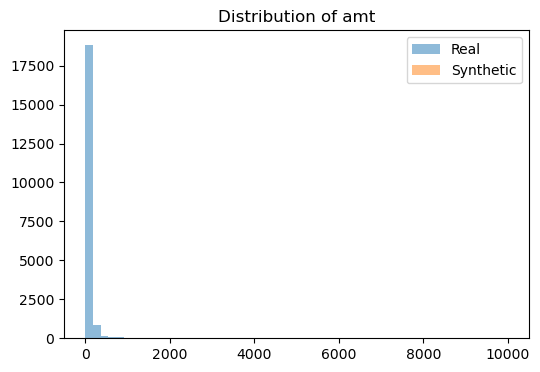

In [15]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

numeric_cols = ['amt']

for col in numeric_cols:
    if col in df.columns and col in synth_df.columns and not synth_df.empty:
        real_vals = pd.to_numeric(df[col], errors='coerce').dropna()
        synth_vals = pd.to_numeric(synth_df[col], errors='coerce').dropna()
        if len(synth_vals) == 0:
            print(f"⚠️ No numeric values for {col} in synthetic data; skipping.")
            continue
        ks = stats.ks_2samp(real_vals, synth_vals)
        print(f"\n📊 KS test for {col}: statistic={ks.statistic:.4f}, p={ks.pvalue:.4f}")
        plt.figure(figsize=(6,4))
        plt.hist(real_vals, bins=30, alpha=0.5, label='Real')
        plt.hist(synth_vals, bins=30, alpha=0.5, label='Synthetic')
        plt.title(f"Distribution of {col}")
        plt.legend()
        plt.show()
    else:
        print(f"⚠️ Column {col} not present in both datasets or synthetic empty; skipping.")


In [16]:
# ===========================================
# Generate and preview synthetic fraud samples
# ===========================================

# 1️⃣ Define the fraud generation prompt
fraud_prompt_template = """
You are an expert synthetic data generator.
Schema fields (at least): trans_date_trans_time, cc_num, merchant, category,
amt, first, last, gender, city, state, zip, job, dob, trans_num, unix_time,
merch_lat, merch_long, is_fraud, reason.

Goal: produce realistic FRAUDULENT transactions (is_fraud must be 1)
covering multiple fraud modes:
- impossible_travel (two transactions for same card in short time thousands of km apart)
- high_amount_unusual_merchant
- probing_small_amounts_sequence
- merchant_location_mismatch
- velocity_burst

Include a short "reason" explaining the fraud mode for each object.
"""

# 2️⃣ Generate synthetic records using your fine-tuned LoRA model (pipeline = gen)
records = generate_synthetic_with_model(
    gen,
    fraud_prompt_template,
    n=50,                 # start small to test
    max_tokens=700,
    temp=0.8,
)

# 3️⃣ Convert to DataFrame and preview
import pandas as pd

if records and len(records) > 0:
    synth_df = pd.DataFrame(records)
    print("\n✅ Parsed synthetic data sample:")
    print("Rows:", len(synth_df))
    display(synth_df.head())
else:
    print("\n⚠️ No synthetic records were generated or parsed correctly.")
    synth_df = pd.DataFrame()  # create an empty fallback so downstream cells won't crash



✅ Parsed synthetic data sample:
Rows: 2


,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,city,state,zip,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,reason
0,2021-04-15T11:22:33.123456Z,4111111111111111,merchant_name,category_name,1000,first_name,last_name,male,city_name,state_abbr,zip_code,job_title,date_of_birth,transaction_num,1617492953,48.856614,2.345679,1,probing_small_amounts_sequence
1,2021-04-15T11:23:33.123456Z,4111111111111112,merchant_name,category_name,999,first_name_2,last_name_2,female,city_name_2,state_abbr_2,zip_code_2,job_title_2,date_of_birth_2,transaction_num_2,1617493002,48.856614,2.345679,1,high_amount_unusual_merchant


In [ ]:
# ----------------------------
# Generate fraud examples for existing users
# ----------------------------
import pandas as pd
import numpy as np
import time
from typing import Dict, List

# Safety: mask PANs so model should not output full real PANs.
def mask_pan(cc: str) -> str:
    s = str(cc or "")
    if len(s) >= 8:
        return s[:4] + "X" * (len(s) - 8) + s[-4:]
    return s

def build_user_prompt(user: Dict, n: int = 5, instruct_fields: List[str] = None) -> str:
    """
    Build a prompt that provides user context and requests `n` fraudulent transactions
    for that user. It asks the model to output a JSON array and to mask PANs.
    """
    if instruct_fields is None:
        instruct_fields = ["first", "last", "city", "state", "zip", "job", "dob"]

    # Build the context lines
    ctx_lines = []
    for f in instruct_fields:
        v = user.get(f, "")
        ctx_lines.append(f"{f}: {v}")

    # Use masked PAN
    cc_masked = mask_pan(user.get("cc_num", ""))
    ctx_lines.append(f"cc_num_masked: {cc_masked}")

    # Recent merchant if available
    if "merchant" in user and pd.notnull(user.get("merchant")):
        ctx_lines.append(f"last_merchant: {user.get('merchant')}")

    ctx = "\n".join(ctx_lines)

    prompt = f"""
You are a realistic transaction synthetic generator. Use the USER CONTEXT below and generate exactly {n} FRAUDULENT transactions for this user.
Output ONLY a JSON array of objects and nothing else. Each object must include at minimum:
- trans_date_trans_time  (ISO timestamp),
- cc_num (MUST BE MASKED: use only X for masked digits; do not reveal full PAN),
- merchant, category, amt (a number), first, last, city, state, zip, job, dob, trans_num, unix_time, merch_lat, merch_long, is_fraud, reason.

USER CONTEXT:
{ctx}

Constraints:
- All transactions MUST belong plausibly to the given user (same first/last and similar demographics).
- All transactions MUST have is_fraud: 1.
- Create a diversity of fraud modes (impossible_travel, high_amount_unusual_merchant, probing_small_amounts_sequence, merchant_location_mismatch, velocity_burst) and include a short "reason" explaining the fraud for each record.
- Use the masked cc_num (cc_num_masked) exactly as provided for the cc_num field.
- Return valid JSON array only. Wrap in ```json fences if you want, but the parser will accept plain arrays.

Return exactly {n} objects in the array.
"""
    return prompt.strip()

def sanitize_and_postprocess_df(df_in: pd.DataFrame) -> pd.DataFrame:
    """Clean amounts, ensure is_fraud and valid timestamps, generate trans_num if missing."""
    d = df_in.copy()
    # Mask PANs again server-side if any leaked
    if 'cc_num' in d.columns:
        d['cc_num'] = d['cc_num'].astype(str).apply(mask_pan)
    # Fix amt
    if 'amt' in d.columns:
        d['amt'] = pd.to_numeric(d['amt'], errors='coerce').fillna(0).clip(lower=0).round(2)
    # Force is_fraud
    d['is_fraud'] = 1
    # Parse timestamps
    if 'trans_date_trans_time' in d.columns:
        d['trans_date_trans_time'] = pd.to_datetime(d['trans_date_trans_time'], errors='coerce')
    # Create trans_num/unix_time if missing
    n = len(d)
    if 'trans_num' not in d.columns or d['trans_num'].isnull().all():
        now_ms = int(time.time()*1000)
        d['trans_num'] = [f"SYN-U-{now_ms+i}" for i in range(n)]
    if 'unix_time' not in d.columns or d['unix_time'].isnull().all():
        d['unix_time'] = d['trans_date_trans_time'].fillna(pd.Timestamp.now()).astype('int64') // 10**9
    # Drop duplicates
    d = d.drop_duplicates()
    return d.reset_index(drop=True)

def generate_for_user(gen_pipeline, user_row: pd.Series, n_per_user: int = 5, verbose: bool = False) -> pd.DataFrame:
    """
    Generates n_per_user fraudulent transactions conditioned on a specific user row.
    Returns a DataFrame (may be empty if parse fails).
    """
    # Build prompt from user row (dict)
    p = build_user_prompt(user_row.to_dict(), n=n_per_user)
    if verbose:
        print("Prompt preview:", p[:400].replace("\n", " ") + " ...")
    records = generate_synthetic_with_model(gen_pipeline, p, n=n_per_user, max_tokens=400, temp=0.7, batch_size=n_per_user, verbose=verbose)
    if not records:
        return pd.DataFrame()
    df = pd.DataFrame(records)
    df = sanitize_and_postprocess_df(df)
    # Ensure first/last match the user (if model changed them)
    if 'first' in user_row and 'last' in user_row:
        df['first'] = user_row.get('first', df.get('first'))
        df['last'] = user_row.get('last', df.get('last'))
    return df

# --------------------
# Example: run for top K users by transaction count (or pick a sample)
# --------------------
K = 50           # number of users to target
N_PER_USER = 10  # how many fraud samples per user

# Choose users: here we pick unique cc_num or unique (first,last,zip) if cc missing
if 'cc_num' in df.columns and df['cc_num'].notnull().any():
    users = df.groupby('cc_num').first().reset_index().head(K)
else:
    users = df.groupby(['first','last','zip']).first().reset_index().head(K)

all_synth = []
for i, user_row in users.iterrows():
    try:
        df_user_synth = generate_for_user(gen, user_row, n_per_user=N_PER_USER, verbose=False)
        if not df_user_synth.empty:
            # attach an origin tag
            df_user_synth['synth_origin_cc'] = mask_pan(user_row.get('cc_num', ''))
            df_user_synth['synth_for_first'] = user_row.get('first', "")
            df_user_synth['synth_for_last'] = user_row.get('last', "")
            all_synth.append(df_user_synth)
        time.sleep(0.1)  # be nice to local resources
    except Exception as e:
        print("Error generating for user:", e)

if all_synth:
    synth_for_existing_users = pd.concat(all_synth, ignore_index=True, sort=False)
else:
    synth_for_existing_users = pd.DataFrame()

print("Generated total synthetic rows for existing users:", len(synth_for_existing_users))
synth_for_existing_users.head(10)



📊 KS test for amt: statistic=0.9973, p=0.0000


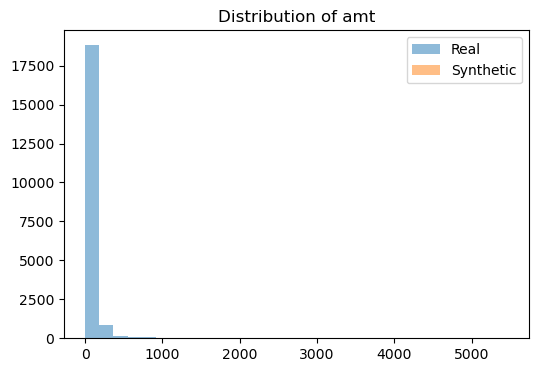

In [17]:
# ================================================
# 7️⃣ Evaluate Synthetic vs Real Data
# ================================================
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

numeric_cols = ['amt']

for col in numeric_cols:
    if col in df.columns and col in synth_df.columns and not synth_df.empty:
        real_vals = pd.to_numeric(df[col], errors='coerce').dropna()
        synth_vals = pd.to_numeric(synth_df[col], errors='coerce').dropna()

        if len(synth_vals) == 0:
            print(f"⚠️ No numeric values for {col} in synthetic data; skipping.")
            continue

        ks = stats.ks_2samp(real_vals, synth_vals)
        print(f"\n📊 KS test for {col}: statistic={ks.statistic:.4f}, p={ks.pvalue:.4f}")

        plt.figure(figsize=(6, 4))
        plt.hist(real_vals, bins=30, alpha=0.5, label='Real')
        plt.hist(synth_vals, bins=30, alpha=0.5, label='Synthetic')
        plt.title(f"Distribution of {col}")
        plt.legend()
        plt.show()
    else:
        print(f"⚠️ Column {col} not present in both datasets or synthetic data empty; skipping.")


In [38]:

# ================================================
# 8️⃣ Save Synthetic Dataset
# ================================================
output_path = "synthetic_transactions_mac.csv"
synth_df.to_csv(output_path, index=False)
print(f"\n💾 Saved synthetic data to {output_path}")


print("\n✅ Fine-tuning complete, synthetic data generated and evaluated!")


💾 Saved synthetic data to synthetic_transactions_mac.csv

✅ Fine-tuning complete, synthetic data generated and evaluated!


In [40]:
def generate_synthetic_with_model(gen_pipeline, prompt: str, n: int, max_tokens: int = 512, temp: float = 0.9):
    out = gen_pipeline(
        prompt + f"\n\nPlease produce {n} records in a valid JSON array. Each record must include is_fraud:1 and a reason field.",
        do_sample=True, temperature=temp, max_new_tokens=max_tokens
    )
    text = out[0]['generated_text']
    # ... (same JSON extraction/parsing code you had)


In [ ]:
!sudo tlmgr install xelatex
!sudo tlmgr install latex-bin \
    geometry fancyhdr ulem hyperref graphics \
    xcolor fontspec booktabs adjustbox collectbox \
    amsmath amssymb enumitem


Password: